## Bootstarp A/B [mini project]

###### The Task:
1. Compare the result of running:
   - Bootstrap mean
   - Bootstrap median
   - Mann-Whitneyu test
2. Write a conclusion based on your results


###### Columns description
* value – metrics value
* experimentVariant – test group (Control, Treatment)

**Importing libraries**

In [80]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

**Importing dataset from a zipped csv-file in the working directory**

In [81]:
df = pd.read_csv('hw_bootstrap.zip', compression='zip', sep=';')

df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


**Checking missing values and columns datatypes**

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


**Renaming columns**

In [83]:
df.rename(columns={'Unnamed: 0': 'seq', 'experimentVariant': 'group'}, inplace=True)

**Replacing delimeter and converting values to a float data type**

In [84]:
df['value'] = df.value.str.replace(',', '.').astype('float')

**Checking data splitting into groups**

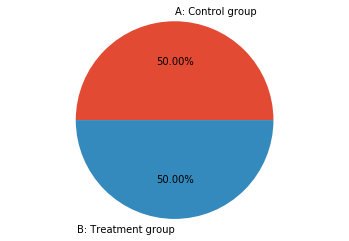

In [85]:
ab_count = df.groupby('group').count().reset_index()

plt.pie(ab_count.value, labels=['A: Control group', 'B: Treatment group'], autopct='%0.2f%%')
plt.axis('equal');

**Split dataframe into two separate dataframes by group criteria ('Control', 'Treatment')**

In [86]:
df_control = df[df['group'] == 'Control']
df_treatment = df[df['group'] == 'Treatment']

**The histogram of 'Control' group values**  
The distribution is close to normal distribution.

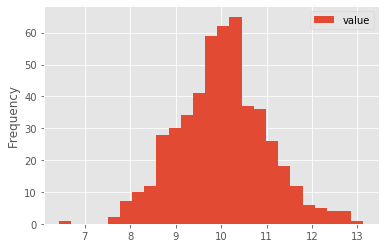

In [87]:
df_control.plot(x='seq', y='value', kind='hist', bins=25);

**Plot 'Control' group values**  
There are no outliers.

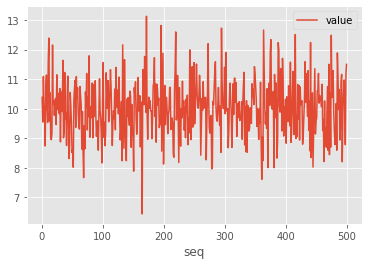

In [88]:
df_control.plot(x='seq', y='value');

**The histogram of 'Treatment' group values**  
The distribution is not normal.

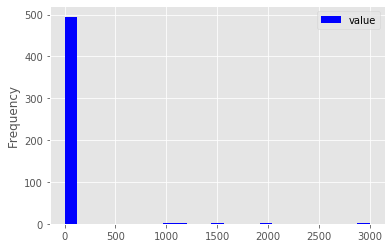

In [89]:
df_treatment.plot(x='seq', y='value', kind='hist', bins=25, color='blue');

**Plot 'Treatment' group values**    
There are outliers closer to the tail of the dataset.

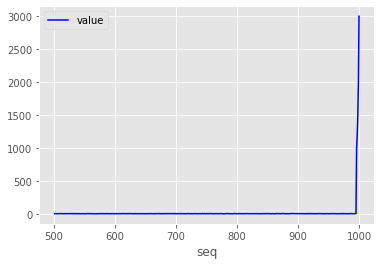

In [90]:
df_treatment.plot(x='seq', y='value', color='blue');

**Checking the tail of the dataset for outliers**   
The last five values seem to be outliers.

In [91]:
df_treatment.tail(10)

,seq,value,group
990,991,10.916229,Treatment
991,992,11.160869,Treatment
992,993,8.202518,Treatment
993,994,9.782199,Treatment
994,995,10.484967,Treatment
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment
999,1000,3000.000000,Treatment


**Getting rid of outliers**

In [92]:
df_treatment_clean = df_treatment.iloc[0:495]

**Plot 'Treatment' group values**   
There are no outliers now.

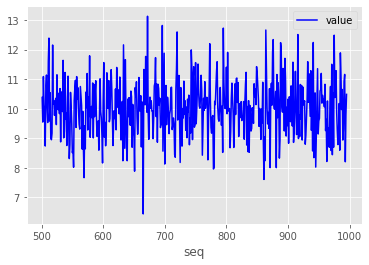

In [93]:
df_treatment_clean.plot(x='seq', y='value', color='blue');

**The histogram of 'Treatment' group values**  
The distribution is close to normal now.

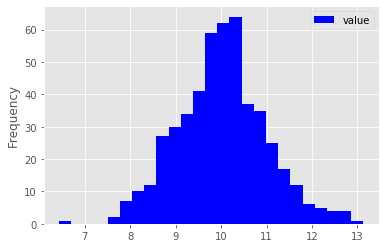

In [94]:
df_treatment_clean.plot(x='seq', y='value', kind='hist', bins=25, color='blue');

**The data is ready. Let's compute the Mann-Whitney rank test**

In [95]:
result = mannwhitneyu(df_control.value, df_treatment_clean.value)
pval_mw_clean = result.pvalue

**Creating bootstrap engine.**

In [96]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, # number of boot-iterations
    statistic = np.mean, # applied staistics
    bootstrap_conf_level = 0.95 # confidence interval
):
    # bootstraping
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    # computing confidence interval
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    
    # defining p-values   
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # rendering
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

**Bootstrap mean**

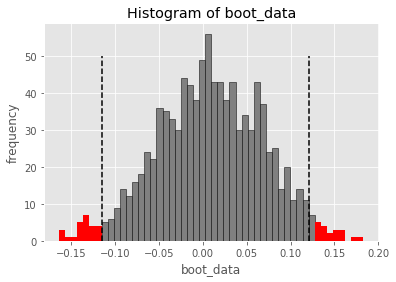

In [97]:
booted_data_mean = get_bootstrap(df_control.value, df_treatment_clean.value, statistic=np.mean);

Zero is inside the confidence interval --> there is no statistically significant reason to reject the Null hypothesis.

**Saving p-value to a variable**

In [98]:
pval_bd_mean_clean = booted_data_mean['p_value']

**Bootstrap median**

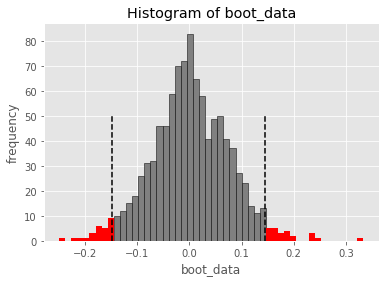

In [99]:
booted_data_median = get_bootstrap(df_control.value, df_treatment_clean.value, statistic=np.median);

Zero is inside the confidence interval --> there is no statistically significant reason to reject the Null hypothesis.

**Saving p-value to a variable**

In [100]:
pval_bd_median_clean = booted_data_median['p_value']

**Conclusion based on the performed tests**

In [101]:
alpha = 0.05
p_vals = {'Mann-Whitney test': pval_mw_clean,
          'Bootstrap mean':pval_bd_mean_clean,
          'Bootstrap median': pval_bd_median_clean}

print(f'''Mann-Whitney p-value: {pval_mw_clean};
Bootstrap mean p-value: {pval_bd_mean_clean};
Bootstrap median p-value: {pval_bd_median_clean}.
''')

for k, v in p_vals.items():
    if v < alpha:
        print(f'After running {k} we have a statistically significant reasons to reject the Null hypothesis and accept the Alternative one.')
    else:
        print(f'{k} didn\'t give us statistically significant reasons to reject the Null hypothesis.')

Mann-Whitney p-value: 0.4614193132073732;
Bootstrap mean p-value: 0.8882601694646931;
Bootstrap median p-value: 0.9769319708368079.

Mann-Whitney test didn't give us statistically significant reasons to reject the Null hypothesis.
Bootstrap mean didn't give us statistically significant reasons to reject the Null hypothesis.
Bootstrap median didn't give us statistically significant reasons to reject the Null hypothesis.


**Re-conduct the test without dropping outliers**

**Compute the Mann-Whitney rank test**

In [102]:
result = mannwhitneyu(df_control.value, df_treatment.value)
pval_mw = result.pvalue

**Bootstrap mean**

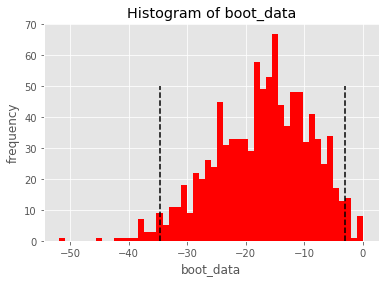

In [103]:
booted_data_mean = get_bootstrap(df_control.value, df_treatment.value, statistic=np.mean);

Zero is outside the confidence interval --> we have a statistically significant reasons to reject the Null hypothesis and accept the Alternative one.

**Saving p-value to a variable**

In [104]:
pval_bd_mean = booted_data_mean['p_value']

**Bootstrap median**

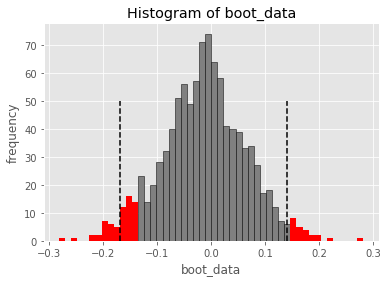

In [105]:
booted_data_median = get_bootstrap(df_control.value, df_treatment.value, statistic=np.median);

Zero is inside the confidence interval --> there is no statistically significant reason to reject the Null hypothesis.

**Saving p-value to a variable**

In [106]:
pval_bd_median = booted_data_median['p_value']

**Conclusion based on the performed tests**

In [107]:
alpha = 0.05
p_vals = {'Mann-Whitney test': pval_mw,
          'Bootstrap mean':pval_bd_mean,
          'Bootstrap median': pval_bd_median}

print(f'''Mann-Whitney p-value: {pval_mw};
Bootstrap mean p-value: {pval_bd_mean};
Bootstrap median p-value: {pval_bd_median}.
''')

for k, v in p_vals.items():
    if v < alpha:
        print(f'After running {k} we have a statistically significant reasons to reject the Null hypothesis and accept the Alternative one.')
    else:
        print(f'{k} didn\'t give us statistically significant reasons to reject the Null hypothesis.')

Mann-Whitney p-value: 0.42960742912427896;
Bootstrap mean p-value: 0.037786122455926545;
Bootstrap median p-value: 0.8619134526897618.

Mann-Whitney test didn't give us statistically significant reasons to reject the Null hypothesis.
After running Bootstrap mean we have a statistically significant reasons to reject the Null hypothesis and accept the Alternative one.
Bootstrap median didn't give us statistically significant reasons to reject the Null hypothesis.


**Summary:**
* If we clear the data from outliers, and carry out all three tests, we'll have the same result (we have no reason to reject the null hypothesis and accept the alternative).
* If the outliers are not removed, then as a result of running Bootstrap mean, we have the reason to reject the null hypothesis and accept the alternative one.
* When we have outliers and use mean statistics to run bootstrap we should pay attention to the results, because this combination of factors can lead us to false positive errors.